In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

def output_to_df(output):
  column_names = [
      "WorkerID",
      "RequestID",
      "ClientRequestTimestamp",
      "ImageOperation",
      "Overwrite",
      "ClientImageID",
      "ServerImageID",
      "ReceiptTimestamp",
      "StartTimestamp",
      "CompletionTimestamp",
      "Event",
      "Count"
  ]

  data = {col: [] for col in column_names}

  with open(output, 'r') as file:
    for line in file:
      match = re.match(r'T(\d+) R(\d+):(\d+\.\d+),([\w\s]+),(\d+),(\d+),(\d+),(\d+\.\d+),(\d+\.\d+),(\d+\.\d+),([\w\s]+),(\d+)', line)
      if match:
        thread_id, request_id, sent_time, image_op, overwrite, client_img_id, server_img_id, receipt_time, start_time, completion_time, event, count = match.groups()

        data["WorkerID"].append(int(thread_id))
        data["RequestID"].append(int(request_id))
        data["ClientRequestTimestamp"].append(float(sent_time))
        data["ImageOperation"].append(image_op)
        data["Overwrite"].append(int(overwrite))
        data["ClientImageID"].append(int(client_img_id))
        data["ServerImageID"].append(int(server_img_id))
        data["ReceiptTimestamp"].append(float(receipt_time))
        data["StartTimestamp"].append(float(start_time))
        data["CompletionTimestamp"].append(float(completion_time))
        data["Event"].append(event)
        data["Count"].append(int(count))

  df = pd.DataFrame(data)

  return df

In [ ]:
df = output_to_df("output-a.txt")
print(len(df["RequestID"]))
df["RequestLength"] = df["CompletionTimestamp"] - df["StartTimestamp"]

dfs = {operation: group for operation, group in df.groupby("ImageOperation")}


862


<ipython-input-11-41e2b3ea3d92>:13: RankWarning: Polyfit may be poorly conditioned
  m, b = np.polyfit(x, y, 1)


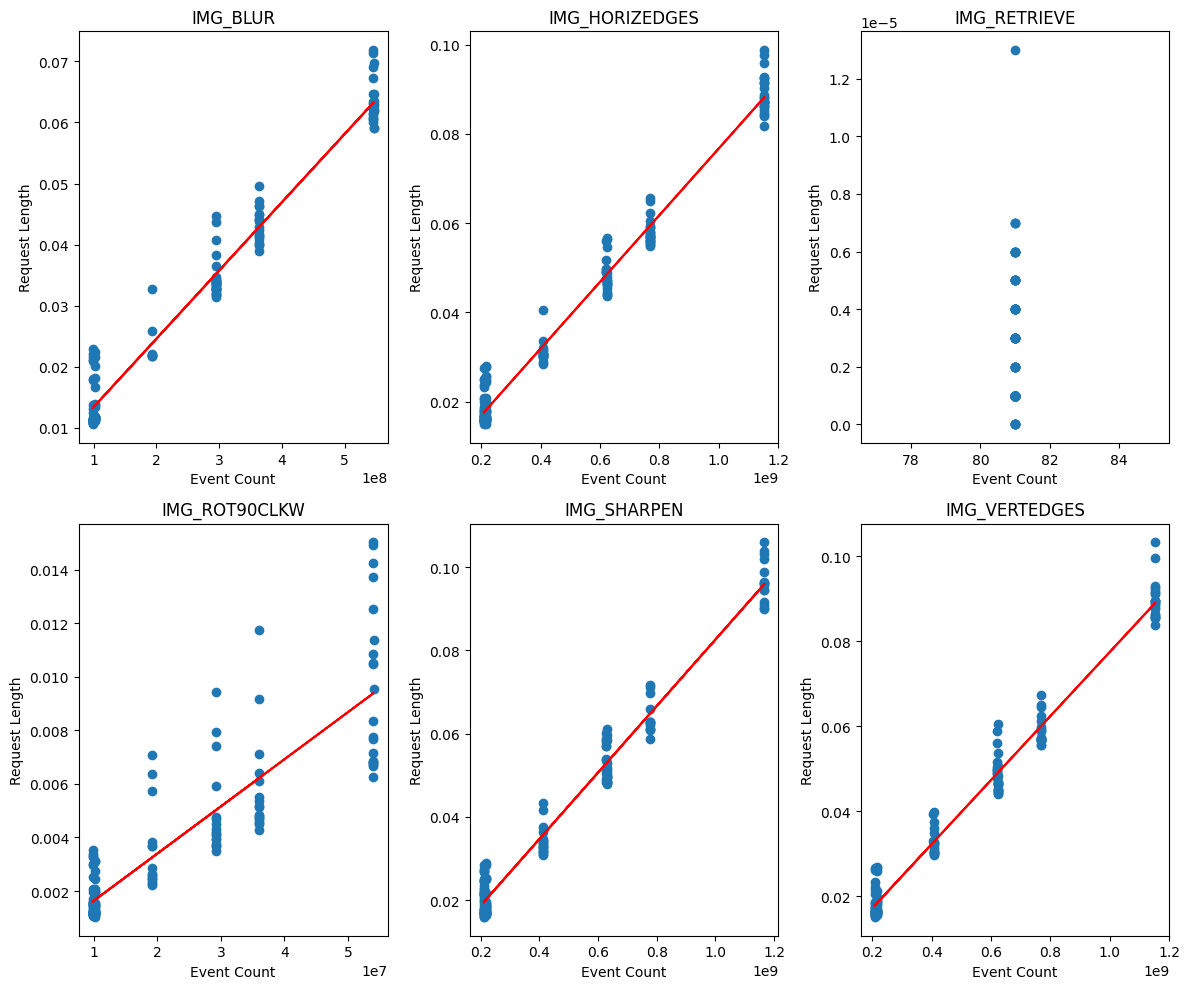

In [ ]:
figs, axs = plt.subplots(2, 3, figsize=(12, 10))
c = 0

for group in dfs:
  if group == "IMG_REGISTER":
    continue;
  x = dfs[group]["Count"]
  y = dfs[group]["RequestLength"]

  ax = axs.flat[c]
  ax.scatter(x, y)

  m, b = np.polyfit(x, y, 1)
  line = m * x + b
  ax.plot(x, line, color="red")

  ax.set_title(f"{group}")
  ax.set_xlabel("Event Count")
  ax.set_ylabel("Request Length")

  c += 1

plt.tight_layout()
plt.show()

As is expected, there appears to be a positive relationship between instruction count and request length. Most of the operations tend to center around a discrete number of instruction counts, with a spread of request lengths around that instruction count. However, IMG_RETRIEVE appears to be centering aroudn only one value of instruction count.

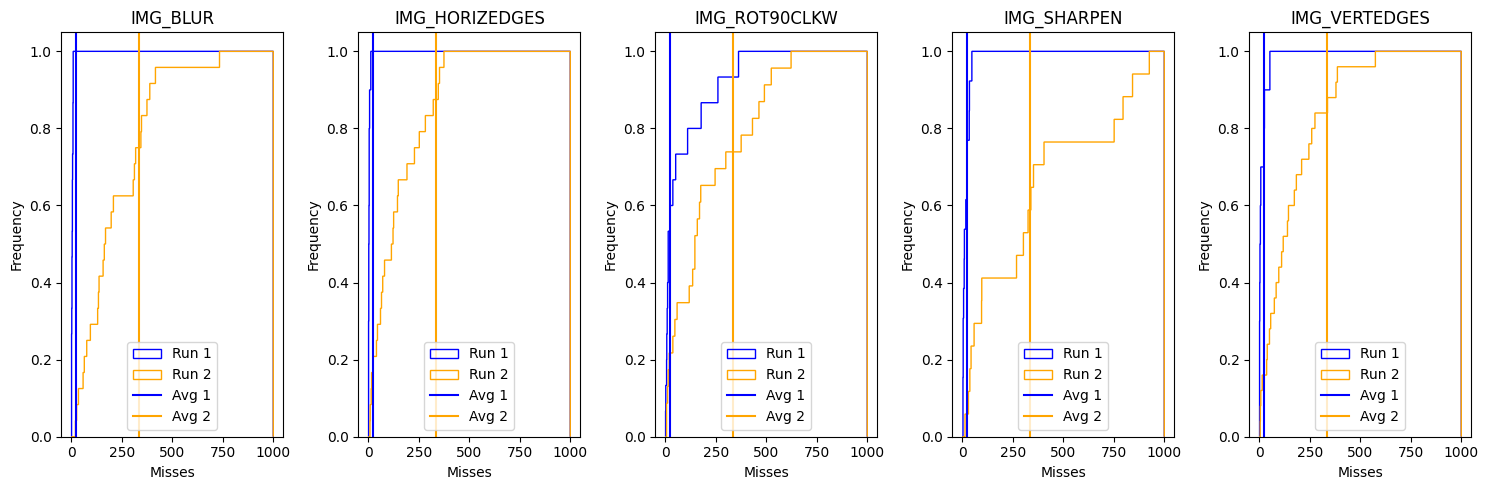

Minimum Run 1: 1
Maximum Run 1: 362
Minimum Run 2: 4
Maximum Run 2: 2412


In [ ]:
df1 = output_to_df("output-b1.txt")
df2 = output_to_df("output-b2.txt")

avg_run1 = np.mean(df1["Count"])
avg_run2 = np.mean(df2["Count"])

dfs = [df1, df2]



operations = ["IMG_BLUR", "IMG_HORIZEDGES", "IMG_ROT90CLKW", "IMG_SHARPEN", "IMG_VERTEDGES"]

op_dfs = {operation: [] for operation in operations}

for df in dfs:
  d = {operation: group for operation, group in df.groupby("ImageOperation")}
  for op in d:
    op_dfs[op].append(d[op])


fig, axs = plt.subplots(1, 5, figsize=(15,5))
c = 0

for operation in operations:
  dfs_runs = op_dfs[operation]
  run1_df = dfs_runs[0]
  run2_df = dfs_runs[1]

  run1_misses = run1_df["Count"]
  run2_misses = run2_df["Count"]

  bins = np.arange(0, 1000, 1)

  ax = axs[c]
  ax.hist(run1_misses, bins=bins, histtype="step", density=True, cumulative=True, label="Run 1", color="blue")
  ax.hist(run2_misses, bins=bins, histtype="step", density=True, cumulative=True, label="Run 2", color="orange")
  ax.set_xlabel("Misses")
  ax.set_ylabel("Frequency")
  ax.set_title(f"{operation}")
  ax.axvline(x=avg_run1, label="Avg 1", color="blue")
  ax.axvline(x=avg_run2, label="Avg 2", color="orange")

  c += 1

  ax.legend()
plt.tight_layout()
plt.show()

print("Minimum Run 1:", np.min(df1["Count"]))
print("Maximum Run 1:", np.max(df1["Count"]))
print("Minimum Run 2:", np.min(df2["Count"]))
print("Maximum Run 2:", np.max(df2["Count"]))










Looking at the CDFS, the average misses, and the maximum and minimums it appears run 1 had far less misses than run 2. This is likely because the same operations were done back to back, as opposed to run 2 where the operations were shuffled, leading to a higher chance of a miss. The data used in the operation will be stored in the cache, and when the same operation is repeated it can reuse this data, but if a different operation is done it may miss. This informs us that the resources being used in our system are stateful, and the order of operations can affect the performance.

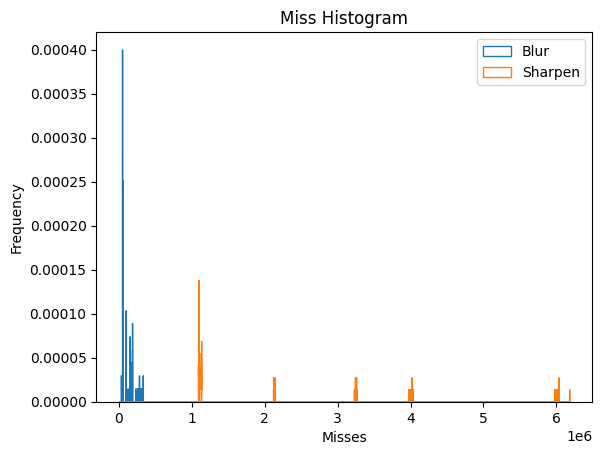

Blur mean: 141347.02222222224
Sharpen mean: 2450039.372413793
Blur max: 335122
Sharpen max: 6182830


In [ ]:
df = output_to_df("output-c.txt")

filtered_df = df[df["ImageOperation"].isin(["IMG_BLUR", "IMG_SHARPEN"])]

blur_df = filtered_df[filtered_df["ImageOperation"] == "IMG_BLUR"]
sharpen_df = filtered_df[filtered_df["ImageOperation"] == "IMG_SHARPEN"]

fig, ax = plt.subplots()

blur_misses = blur_df["Count"]
sharpen_misses = sharpen_df["Count"]

bin_width = 500
bins = np.arange(0, np.max(sharpen_misses) + bin_width, bin_width)

ax.hist(blur_misses, bins=bins, density=True, cumulative=False, histtype="step", label="Blur")
ax.hist(sharpen_misses, bins=bins, density=True, cumulative=False, histtype="step", label="Sharpen")

ax.set_xlabel("Misses")
ax.set_ylabel("Frequency")
ax.set_title("Miss Histogram")

plt.legend()
plt.show()


print("Blur mean:", np.mean(blur_misses))
print("Sharpen mean:", np.mean(sharpen_misses))

print("Blur max:", np.max(blur_misses))
print("Sharpen max:", np.max(sharpen_misses))







It seems like the blur operation has fewer misses than sharpen. This could be because of the conditional logic at the end of the sharpen operation, which could cause the need for greater memory, leading to more cache misses. Sharpen image also uses different weights for each surrounding pixel, which could lead to further computation and thus more cache misses.